<a href="https://colab.research.google.com/github/sinood/cs194-26_proj4_p3/blob/master/Neural_Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
import skimage.io as skio
import datetime
import cv2
import scipy.stats as st
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import copy

DEVICE = torch.device("cuda")
# device = torch.device("cpu")
SIZE = 256
PATH = '/content/drive/MyDrive/cs194-26_finalproj_ims/'

Loss functions

In [178]:


def get_gram_mat(input):
    batchsize, num_features, feature_rows, feature_cols = input.size()
    features = input.view(batchsize*num_features, feature_rows*feature_cols)
    gram_mat = torch.mm(features, features.t())
    gram_mat = gram_mat.div(batchsize*num_features*feature_rows*feature_cols)
    return gram_mat

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = get_gram_mat(target_feature).detach()

    def forward(self, input):
        gram_mat = get_gram_mat(input)
        self.loss = F.mse_loss(gram_mat, self.target)
        return input

class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, im):
        return (im - self.mean) / self.std

def insert_loss_layers(model, im_content, im_style,
                content_loss_layers=['conv_4'],
                style_loss_layers=['conv_1', 'conv_2', 'conv_3','conv_4', 'conv_5']):
    model = copy.deepcopy(model)
    normalize = Normalize(mean=torch.tensor([0.40760392, 0.45795686, 0.48501961]).to(DEVICE),
                          std=torch.tensor([1,1,1]).to(DEVICE))
    new_model = nn.Sequential(normalize)

    losses_content = []
    losses_style = []
    i = 0
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
            # Change max pool layers to avg pool
            layer = nn.AvgPool2d(kernel_size=2, stride=2)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        new_model.add_module(name, layer)

        if name in content_loss_layers:
            target = new_model(im_content).detach()
            content_loss = ContentLoss(target)
            new_model.add_module("content_{}".format(i), content_loss)
            losses_content.append(content_loss)

        if name in style_loss_layers:
            target_feature = new_model(im_style).detach()
            style_loss = StyleLoss(target_feature)
            new_model.add_module("style_{}".format(i), style_loss)
            losses_style.append(style_loss)

    # Don't want the remaining layers, just the loss layers we added, so clip the rest
    last_layer = i
    for j in range(len(new_model)-1,-1,-1):
        if isinstance(new_model[i], ContentLoss) or isinstance(new_model[i], StyleLoss):
            last_layer = j
            break
    new_model = new_model[:last_layer+1]

    return new_model, losses_content, losses_style
  
def transfer(model_pre, im_content, im_style, input, iters=500, weight_style=1000000, weight_content=1):
    t0 = datetime.datetime.now()
    print('Creating model')
    model, content_losses, style_losses = insert_loss_layers(model_pre, im_style, im_content)
    print(model)
    optimizer = optim.LBFGS([input.requires_grad_()])
    t1 = datetime.datetime.now()
    print('Model creation: {}'.format(t1-t0))
    print('Running optimization loop')
    iter_num = 0
    style_loss_failed = 0
    total_style_loss_tries = 0
    while iter_num <= iters:

        def combined_loss():
            nonlocal iter_num, total_style_loss_tries, style_loss_failed
            input.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input)
            loss_c = 0
            loss_s = 0
            for l in content_losses:
              loss_c = loss_c + l.loss
            for l in style_losses:
                total_style_loss_tries = total_style_loss_tries + 1
                try:
                    loss_s = loss_s + l.loss
                except:
                    style_loss_failed = style_loss_failed + 1
            loss = loss_s*weight_style + loss_c*weight_content
            # print(len(content_losses), len(style_losses))
            loss.backward()
            iter_num += 1
            if iter_num % 50 == 0:
                print('{} content: {:3f} style: {:3f}'.format(iter_num,
                    loss_c.item(), loss_s.item()))
            return loss_s + loss_c

        optimizer.step(combined_loss)
    input.data.clamp_(0, 1)
    t2 = datetime.datetime.now()
    print('Style loss failed {} out of {} times'.format(style_loss_failed, total_style_loss_tries))
    print('Total time: {}'.format(t2-t1))
    return input



In [148]:
model = models.vgg19(pretrained=True).features
model = model.to(DEVICE)
model = model.eval()


Image loading 

In [75]:
# Need to make images same size and convert them to tensors
im_adjust = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor()])
im_convert = transforms.ToPILImage()

def imload(imname):
    im = Image.open(imname)
    im = im_adjust(im)
    im = im.unsqueeze(0)
    return im.to(DEVICE, torch.float)

def display_tensor_im(im_tensor):
    plt.figure()
    im = im_tensor.cpu().clone()
    im = im_convert(im.squeeze(0))
    plt.imshow(im)


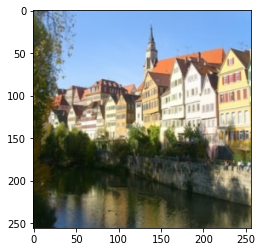

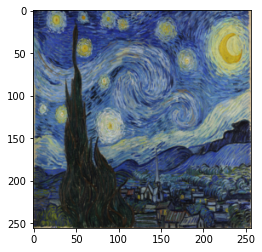

In [78]:
content_im = imload(PATH+'neckarfront.jpg')
style_im = imload(PATH+'starrynight.jpg')
display_tensor_im(content_im)
display_tensor_im(style_im)

Creating model
Sequential(
  (0): Normalize()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_4): ContentLoss()
  (style_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Model creation: 0:00:00.019716
Running optimization loop


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


50 content: 0.641124 style: 0.000001
100 content: 0.406932 style: 0.000000
150 content: 0.358451 style: 0.000000
200 content: 0.396907 style: 0.000000
250 content: 0.380465 style: 0.000000
300 content: 0.425265 style: 0.000000
350 content: 10.133313 style: 0.001265
400 content: 0.719244 style: 0.000000
450 content: 0.392461 style: 0.000000
500 content: 0.355354 style: 0.000000
Style loss failed 520 out of 2600 times
Total time: 0:00:12.856320


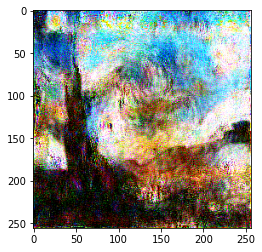

In [180]:
input = torch.randn(content_im.data.size(), device=DEVICE) # White noise img
output = transfer(model, content_im, style_im, input)

display_tensor_im(output)
plt.show()

In [77]:
model_modified, loss_content, loss_style = insert_loss_layers(model, content_im, style_im)
# print(loss_style)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
